In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from contextlib import contextmanager
from pathlib import Path
import functools

from tqdm import tqdm
from einops import rearrange, reduce, einsum
import plotly.express as px
import plotly.graph_objects as go
import torch
from cupbearer import detectors, tasks, utils, scripts
from torch import Tensor, nn

In [3]:
task = tasks.tiny_natural_mechanisms("hex", device="mps")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [4]:
with open(".cupbearer_cache/tiny_natural_mechanisms/hex_task.json") as f:
    task_config = json.load(f)

# cpu to avoid MPS issues with tensors that are too large
effect_tokens = torch.tensor(
    task_config["effect_tokens"], dtype=torch.long, device="cpu"
)

In [5]:
for name, _ in task.model.named_modules():
    print(name)


embed
hook_embed
pos_embed
hook_pos_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
ln_final
ln_final.hook_scale
ln_final.hook_normalized
unembed


# Defining the detector

In [6]:
def effect_prob_func(logits):
    assert logits.ndim == 3
    probs = logits.softmax(-1)
    # Sum over vocab (but not batch) dim:
    return probs[:, -1, effect_tokens].sum(-1)

In [7]:
class GradientWeightedDetector(detectors.AnomalyDetector):
    def __init__(self, names: list[str], output_func):
        super().__init__()
        self.names = names
        self.output_func = output_func

    def train(
        self,
        trusted_data: torch.utils.data.Dataset,
        untrusted_data: torch.utils.data.Dataset | None,
        save_path: Path | str | None,
        batch_size: int = 64,
        **kwargs,
    ):
        assert trusted_data is not None

        data_loader = torch.utils.data.DataLoader(
            trusted_data, batch_size=batch_size, shuffle=False
        )
        example_batch = next(iter(data_loader))
        example_inputs = utils.inputs_from_batch(example_batch)
        example_activations = utils.get_activations(
            self.model, self.names, example_inputs
        )

        # v is an entire batch, v[0] are activations for a single input
        activation_sizes = {k: v[0].size() for k, v in example_activations.items()}
        device = next(iter(example_activations.values())).device

        for k, size in activation_sizes.items():
            if len(size) not in (1, 2):
                raise ValueError(
                    f"Activation size {size} of {k} is not supported. "
                    "Activations must be either 1D or 2D (in which case separate "
                    "covariance matrices are learned along the first dimension)."
                )
        self.means = {
            k: torch.zeros(size[-1], device=device)
            for k, size in activation_sizes.items()
        }
        self.Pi = {
            k: torch.zeros((size[-1], size[-1]), device=device)
            for k, size in activation_sizes.items()
        }
        self._n = 0

        for i, batch in enumerate(tqdm(data_loader)):
            inputs = utils.inputs_from_batch(batch).to(device)
            activations, grads = utils.get_activations_and_grads(
                self.model, self.names, self.output_func, inputs
            )

            for k in self.names:
                # Flatten the activations to (batch, dim)
                activation = activations[k]
                grad = grads[k]

                assert activation.shape == grad.shape

                if activation.ndim == 3:
                    activation = rearrange(
                        activation, "batch independent dim -> (batch independent) dim"
                    )
                    grad = rearrange(
                        grad, "batch independent dim -> (batch independent) dim"
                    )
                assert activation.ndim == 2, activation.shape

                new_n = len(activation)
                total_n = self._n + new_n

                new_mean = activation.mean(dim=0)
                self.means[k] = (self._n * self.means[k] + new_n * new_mean) / total_n

                # Compute outer product, then take the mean over the batch dimension
                new_C = torch.einsum("bi, bj -> ij", grad, grad) / new_n
                self.Pi[k] = (self.Pi[k] * self._n + new_C * new_n) / total_n

                self._n = total_n

    def layerwise_scores(self, batch):
        inputs = utils.inputs_from_batch(batch).to("mps")

        activations, grads = utils.get_activations_and_grads(
            self.model, self.names, self.output_func, inputs
        )
        batch_size = next(iter(activations.values())).shape[0]

        distances: dict[str, torch.Tensor] = {}
        # Reshape activations to (batch, dim) for computing distances
        for k in self.names:
            activation = activations[k]
            grad = grads[k]
            assert activation.shape == grad.shape
            if activation.ndim == 3:
                activation = rearrange(
                    activation, "batch independent dim -> (batch independent) dim"
                )
                grad = rearrange(
                    grad, "batch independent dim -> (batch independent) dim"
                )
            assert activation.ndim == 2, activation.shape

            delta = activation - self.means[k]
            distance = torch.einsum("bi,ij,bj->b", delta, self.Pi[k], delta)
            distances[k] = distance

        for k, v in distances.items():
            # Unflatten distances so we can take the mean over the independent axis
            distances[k] = rearrange(
                v, "(batch independent) -> batch independent", batch=batch_size
            ).mean(dim=1)

        return distances

    def _get_trained_variables(self, saving: bool = False):
        return {
            "means": self.means,
            "Pi": self.Pi,
        }

    def _set_trained_variables(self, variables):
        self.means = variables["means"]
        self.Pi = variables["Pi"]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 256/256 [00:39<00:00,  6.43it/s]


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-05-01 23:02:29.151 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.6257
2024-05-01 23:02:29.151 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.5995


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.6256933212280273,
               'AP': 0.599535524616711}}),
 {'all': <Figure size 640x480 with 1 Axes>})

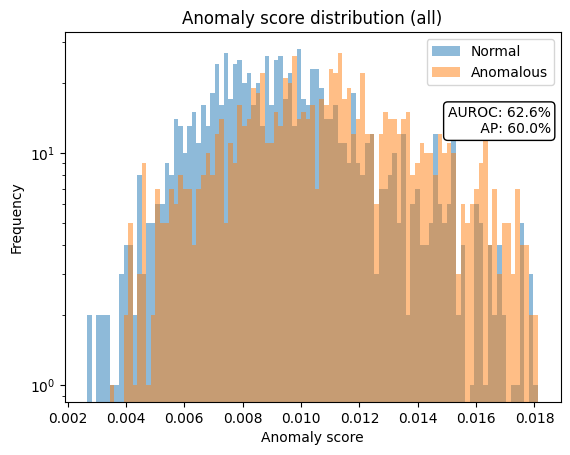

In [8]:
names = [
    "blocks.0.hook_attn_out.output",
    # "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",
    "ln_final.hook_normalized.output",
]
detector = GradientWeightedDetector(names=names, output_func=effect_prob_func)
scripts.train_detector(task, detector, save_path=None, eval_batch_size=64)

In [1]:
px.imshow(detector.Pi["blocks.0.hook_attn_out.output"].cpu(), binary_string=True)

NameError: name 'px' is not defined